In [1]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

In [2]:
from gridworld_v03_1 import gameEnv
env = gameEnv(partial=False, size=10)

In [3]:
class Qnetwork():
    def __init__(self, h_size, name = "main"):
        self.h_size = h_size
        self.net_name = name
        
        self.build_network()
        
    def build_network (self): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
      
    #    self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
    #    self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        with tf.variable_scope(self.net_name):
            # Input(return value of env.reset) dimension
            # self.dimX = env.?

            self.dimX = len(env.objects) * 2
            self.dimY = env.actions

            # Dimensions of each layer 
            self.nInputLayer = self.dimX
            self.nHidden1 = h_size
            self.nHidden2 = (int)(h_size / 2 )
            self.nHidden3 = (int)(h_size / 4)
            self.nOutputLayer = self.dimY

            self.input = tf.placeholder(shape=[None, self.dimX], dtype=tf.float32)
            self.output = tf.placeholder(shape=[None, self.dimY], dtype=tf.float32)

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [self.nInputLayer, self.nHidden1]),
                'W2': self.init_weight("W2", [self.nHidden1, self.nHidden2]),
                'W3': self.init_weight("W3", [self.nHidden2, self.nHidden3]),
                'W4': self.init_weight("W4", [self.nHidden3, self.nOutputLayer])
            }

            # Bias of each layer
            self.b = {
                'b1': self.init_bias(self.nHidden1),
                'b2': self.init_bias(self.nHidden2),
                'b3': self.init_bias(self.nHidden3),
                'b4': self.init_bias(self.nOutputLayer)
            }

            # If we need,
            self.dropProb = 0.0


            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.input, self.W['W1']), self.b['b1']))
            # self.hidden1 = tf.nn.dropout(self.hidden1, self.dropProb)

            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            # self.hidden2 = tf.nn.dropout(self.hidden2, self.dropProb)

            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))
            # self.hidden3 = tf.nn.dropout(self.hidden3, self.dropProb)

            self.output = tf.add(tf.matmul(self.hidden3, self.W['W4']), self.b['b4'])

            """
            self.conv1 = slim.conv2d(inputs=self.imageIn,
                                     num_outputs=32,
                                     kernel_size=[8,8],
                                     stride=[4,4],
                                     padding='VALID', 
                                     biases_initializer = None)

            self.conv2 = slim.conv2d(inputs=self.conv1,
                                     num_outputs=64,
                                     kernel_size=[4,4],
                                     stride=[2,2],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv3 = slim.conv2d(inputs=self.conv2,
                                     num_outputs=64,
                                     kernel_size=[3,3],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv4 = slim.conv2d(inputs=self.conv3,
                                     num_outputs=h_size,
                                     kernel_size=[7,7],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)
             """

            #We take the output from the final convolutional layer and split it into separated terms: advantage & value
            # I think the input dimension of our env is 1-dim 
            self.streamAC, self.streamVC = tf.split(self.output, 2, 1)
            self.streamA = slim.flatten(self.streamAC)
            self.streamV = slim.flatten(self.streamVC)

            xavier_init = tf.contrib.layers.xavier_initializer()

            self.AW = tf.Variable(xavier_init([self.dimY//2, env.actions]))
            self.VM = tf.Variable(xavier_init([self.dimY//2, 1]))

            self.Advantage = tf.matmul(self.streamA, self.AW)
            self.Value = tf.matmul(self.streamV, self.VM)

            #Then combine to obtain the final Q-value //why substract mean from Advantage?
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
            self.predict = tf.argmax(self.Qout, 1)

            #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)

            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)    
            
    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

    def init_bias(self, n):
        return tf.Variable(tf.random_normal([n]))

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [5]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [6]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [7]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [8]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 4 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 10000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 10000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 10000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 100

load_model = False #Wheter to load a saved model
path = "./log3" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [9]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        # s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.input:[s]})[0]
            s1,r,d = env.step(a)
            #print(s1, r, d)
            #s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.input:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.input:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.input:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
Saved Model
279 -0.96 1
521 -1.16 1
1104 -1.56 1
1527 -1.6 1
2158 -2.02 1
2534 -1.32 1
3212 -1.68 1
3732 -1.62 1
4075 -1.58 1
4367 -1.36 1

=====Episode 100start =====
4864 -1.46 1
5113 -0.66 1
5423 -1.62 1
5817 -1.52 1
6206 -0.96 1
6512 -1.02 1
6818 -1.0 1
7302 -1.28 1
7811 -1.34 1
8160 -1.76 1

=====Episode 200start =====
8488 -1.1 1
8861 -1.68 1
9405 -1.62 1
9688 -1.2 1
9945 -1.26 1
10370 -1.52 0.9666999999999872
10802 -1.2 0.9278199999999723
11264 -1.74 0.8862399999999564
11766 -2.14 0.8410599999999391
12107 -1.66 0.8103699999999273

=====Episode 300start =====
12542 -2.06 0.7712199999999123
13008 -2.4 0.7292799999998962
13476 -2.16 0.6871599999998801
14010 -3.48 0.6390999999998617
14342 -1.94 0.6092199999998502
14779 -2.02 0.5698899999998351
15181 -1.72 0.5337099999998213
15543 -2.3 0.5011299999998088
16032 -3.04 0.4571199999998184
16533 -3.6 0.4120299999998289

=====Episode 400start =====
17060 -3.32 0.36459999999984
17577 -4.0 0.31806999999985086
18227

191076 0.12 0.09999999999985551
191753 0.26 0.09999999999985551

=====Episode 2500start =====
192512 0.28 0.09999999999985551
193322 -0.1 0.09999999999985551
194207 0.04 0.09999999999985551
194768 0.44 0.09999999999985551
195509 -0.1 0.09999999999985551
196136 0.3 0.09999999999985551
197043 0.1 0.09999999999985551
197853 0.12 0.09999999999985551
198853 -0.04 0.09999999999985551
199663 0.06 0.09999999999985551

=====Episode 2600start =====
200354 -0.22 0.09999999999985551
201085 0.32 0.09999999999985551
202006 -0.02 0.09999999999985551
202815 0.02 0.09999999999985551
203686 0.06 0.09999999999985551
204580 0.08 0.09999999999985551
205322 0.38 0.09999999999985551
206080 0.22 0.09999999999985551
206817 -0.06 0.09999999999985551
207685 -0.12 0.09999999999985551

=====Episode 2700start =====
208547 0.16 0.09999999999985551
209409 -0.86 0.09999999999985551
210209 -0.04 0.09999999999985551
210962 0.06 0.09999999999985551
211816 0.38 0.09999999999985551
212527 0.2 0.09999999999985551
213406 0.2

313116 0.9 0.09999999999985551
313496 0.68 0.09999999999985551
313686 0.7 0.09999999999985551
314080 0.62 0.09999999999985551
314236 0.78 0.09999999999985551
314768 0.46 0.09999999999985551
315099 0.56 0.09999999999985551
315479 0.68 0.09999999999985551

=====Episode 4900start =====
315636 0.9 0.09999999999985551
315984 0.6 0.09999999999985551
316163 0.88 0.09999999999985551
316486 0.36 0.09999999999985551
316796 0.74 0.09999999999985551
317204 0.44 0.09999999999985551
317547 0.58 0.09999999999985551
317944 0.66 0.09999999999985551
318115 0.88 0.09999999999985551
318489 0.44 0.09999999999985551

=====Episode 5000start =====
Saved Model
318648 0.9 0.09999999999985551
319110 0.68 0.09999999999985551
319537 0.26 0.09999999999985551
320059 0.54 0.09999999999985551
320258 0.9 0.09999999999985551
320603 0.48 0.09999999999985551
320850 0.9 0.09999999999985551
321287 0.46 0.09999999999985551
321454 0.9 0.09999999999985551
321915 0.5 0.09999999999985551

=====Episode 5100start =====
322096 0.9 

382577 0.68 0.09999999999985551

=====Episode 7200start =====
382823 0.7 0.09999999999985551
383105 0.7 0.09999999999985551
383363 0.86 0.09999999999985551
383864 0.52 0.09999999999985551
384133 0.9 0.09999999999985551
384504 0.5 0.09999999999985551
384858 0.88 0.09999999999985551
385120 0.76 0.09999999999985551
385306 0.84 0.09999999999985551
385890 0.48 0.09999999999985551

=====Episode 7300start =====
386076 0.86 0.09999999999985551
386479 0.62 0.09999999999985551
386813 0.78 0.09999999999985551
387342 0.58 0.09999999999985551
387627 0.88 0.09999999999985551
388175 0.58 0.09999999999985551
388581 0.54 0.09999999999985551
389033 0.68 0.09999999999985551
389356 0.88 0.09999999999985551
389713 0.8 0.09999999999985551

=====Episode 7400start =====
389980 0.54 0.09999999999985551
390353 0.7 0.09999999999985551
390660 0.9 0.09999999999985551
390981 0.78 0.09999999999985551
391199 0.7 0.09999999999985551
391519 0.58 0.09999999999985551
391725 0.88 0.09999999999985551
392004 0.78 0.09999999

460989 0.68 0.09999999999985551
461416 0.3 0.09999999999985551
461903 0.6 0.09999999999985551
462259 0.78 0.09999999999985551
462633 0.56 0.09999999999985551
463037 0.36 0.09999999999985551

=====Episode 9600start =====
463425 0.76 0.09999999999985551
463675 0.28 0.09999999999985551
463916 0.9 0.09999999999985551
464261 0.7 0.09999999999985551
464466 0.88 0.09999999999985551
464866 0.54 0.09999999999985551
465396 0.58 0.09999999999985551
465744 0.52 0.09999999999985551
466147 0.78 0.09999999999985551
466358 0.64 0.09999999999985551

=====Episode 9700start =====
466722 0.76 0.09999999999985551
467016 0.82 0.09999999999985551
467393 0.68 0.09999999999985551
467703 0.76 0.09999999999985551
467940 0.68 0.09999999999985551
468360 0.6 0.09999999999985551
468752 0.56 0.09999999999985551
469070 0.34 0.09999999999985551
469434 -0.24 0.09999999999985551
469743 0.72 0.09999999999985551

=====Episode 9800start =====
470170 0.76 0.09999999999985551
470556 0.54 0.09999999999985551
470841 0.78 0.0999

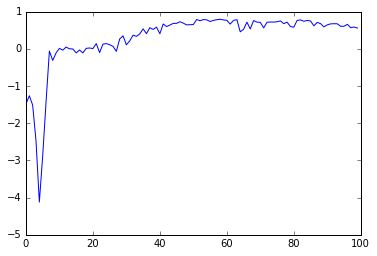

In [11]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [13]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [14]:
sess = tf.InteractiveSession()

In [15]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs/model-29999.cptk


[2017-06-05 16:39:39,215] Restoring parameters from ./dqn_logs/model-29999.cptk


In [16]:
#Reset environment and get the first new observation
s = env.reset()
#s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 1
Reward: 0 , Done: False


TypeError: Invalid dimensions for image data

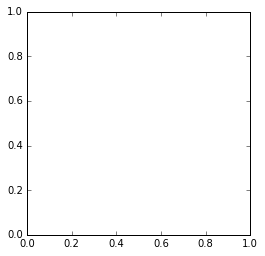

In [17]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
#s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [18]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [12]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        #s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
           #s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./log3/model-9999.cptk


[2017-06-06 01:59:50,932] Restoring parameters from ./log3/model-9999.cptk


437	0.6
876	0.6
1313	0.6
1752	0.6
2189	0.6
2628	0.6
3065	0.6
3504	0.6
3941	0.6
4380	0.6
4817	0.6
5256	0.6
5693	0.6
6132	0.6
6569	0.6
7008	0.6
7445	0.6
7884	0.6
8321	0.6
8760	0.6
9197	0.6
9636	0.6
10073	0.6
10512	0.6
10949	0.6
11388	0.6
11825	0.6
12264	0.6
12701	0.6
13140	0.6
13577	0.6
14016	0.6
14453	0.6
14892	0.6
15329	0.6
15768	0.6
16205	0.6
16644	0.6
17081	0.6
17520	0.6
17957	0.6
18396	0.6
18833	0.6
19272	0.6
19709	0.6
20148	0.6
20585	0.6
21024	0.6
21461	0.6
21900	0.6
22337	0.6
22776	0.6
23213	0.6
23652	0.6
24089	0.6
24528	0.6
24965	0.6
25404	0.6
25841	0.6
26280	0.6
26717	0.6
27156	0.6
27593	0.6
28032	0.6
28469	0.6
28908	0.6
29345	0.6
29784	0.6
30221	0.6
30660	0.6
31097	0.6
31536	0.6
31973	0.6
32412	0.6
32849	0.6
33288	0.6
33725	0.6
34164	0.6
34601	0.6
35040	0.6
35477	0.6
35916	0.6
36353	0.6
36792	0.6
37229	0.6
37668	0.6
38105	0.6
38544	0.6
38981	0.6
39420	0.6
39857	0.6
40296	0.6
40733	0.6
41172	0.6
41609	0.6
42048	0.6
42485	0.6
42924	0.6
43361	0.6
43800	0.6
44237	0.6
44676	0.6
4511

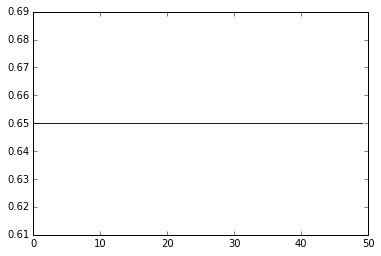

In [20]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [35]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

62	-0.6
140	-1.0
248	-1.0
367	-0.8
427	-0.8
564	-0.6
607	-0.6
730	-0.9
806	-0.8
891	-0.6
1013	-1.0
1129	-0.8
1209	-0.4
1307	-0.6
1406	-0.9
1508	-0.6
1562	-1.0
1608	-1.0
1751	-0.8
1836	-0.8
1912	-0.6
2003	-0.6
2101	-0.8
2194	-1.0
2268	-1.0
2314	-0.8
2394	-0.6
2477	-1.0
2575	-1.0
2671	-1.0
2753	-0.8
2828	-0.8
2936	-0.8
3003	-1.0
3082	-0.6
3173	-0.6
3318	-0.6
3429	-0.8
3575	-0.5
3740	-0.4
3828	-0.2
3975	-0.8
4082	-1.0
4133	-0.8
4202	-0.8
4267	-0.6
4386	-0.8
4505	-0.4
4626	-0.4
4693	-1.0
4745	-0.8
4792	-0.8
4860	-0.6
4974	-0.9
5031	-0.6
5066	-0.8
5207	-0.8
5313	-0.6
5410	-0.8
5513	-1.0
5582	-0.8
5683	-0.6
5811	-1.0
5865	-0.8
5954	-0.8
6006	-0.2
6121	-1.0
6246	-0.8
6300	-0.8
6394	-0.6
6516	-0.7
6616	-0.8
6679	-0.4
6758	-0.6
6842	-0.4
6887	-0.4
6955	-0.8
7006	-0.6
7111	-0.8
7225	-0.4
7268	-1.0
7397	-0.8
7455	-0.6
7529	-1.0
7564	-0.6
7643	-0.8
7731	-0.8
7886	-1.0
7990	-0.6
8073	-0.8
8120	-0.6
8186	-1.0
8213	-0.8
8283	-0.4
8357	-0.8
8417	-0.8
8510	-1.0
8649	-1.0
8715	-0.4
8798	-0.8
8884	-0.6
8

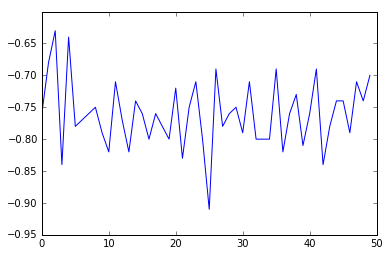

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)